### 

### Case Study: Prediciton of Housing Price using synthetic data.

In [29]:
# imporitng needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

np.random.seed(42)

# Generating a synthetic housing dataset
size = np.random.normal(1500, 500, 100)
bedrooms = np.random.randint(1, 5, 100)
age = np.random.randint(1, 30, 100)
price = 200 + (size * 0.1) + (bedrooms * 15) - (age * 2) + np.random.normal(0, 25, 100)

# Manually adding null values here
# Convert bedrooms and age varibales to float to allow for NaN values
bedrooms = bedrooms.astype(float)
age = age.astype(float)

# Introduce missing values randomly
num_missing = int(0.1 * 100)  # 10% of data as missing
missing_indices_size = np.random.choice(100, num_missing, replace=False)
missing_indices_bedrooms = np.random.choice(100, num_missing, replace=False)
missing_indices_age = np.random.choice(100, num_missing, replace=False)

size[missing_indices_size] = np.nan
bedrooms[missing_indices_bedrooms] = np.nan
age[missing_indices_age] = np.nan

# Using a DataFrame df to handle data and interpolation
df = pd.DataFrame({'size': size, 'bedrooms': bedrooms, 'age': age, 'price': price})

# Interpolating missing values and filling any remaining NaNs with column mean
df_interpolated = df.interpolate(method='linear', limit_direction='forward', axis=0).fillna(df.mean())

# Preparing the data for modeling
X = df_interpolated[['size', 'bedrooms', 'age']].values
y = df_interpolated['price'].values.reshape(-1, 1)

# Adding a column of ones for the intercept term
X = np.column_stack((np.ones(X.shape[0]), X))

# Normal Equation Function
def normal_equation(X, y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

# Calculating the optimal coefficients using the Normal Equation
beta = normal_equation(X, y)

# Feature Scaling for Improved Gradient Descent
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[:, 1:])
X_scaled = np.column_stack((np.ones(X_scaled.shape[0]), X_scaled))

# Gradient Descent Function
def gradient_descent(X, y, learning_rate=0.1, iterations=5000):
    m = len(y)
    theta = np.zeros((X.shape[1], 1))
    cost_history = []

    for _ in range(iterations):
        predictions = X.dot(theta)
        errors = predictions - y
        gradients = 2 / m * X.T.dot(errors)
        theta -= learning_rate * gradients
        cost = np.sum(errors ** 2) / (2 * m)
        cost_history.append(cost)

    return theta, cost_history

# Performing Gradient Descent
theta_gd, _ = gradient_descent(X_scaled, y, learning_rate=0.1, iterations=5000)

# Calculating predictions
y_pred_normal = X.dot(beta)
y_pred_gd = X_scaled.dot(theta_gd)

# Calculating and print RMSE and MSE for Gradient Descent with respect to the Normal Equation predictions
mse_gd_vs_normal = mean_squared_error(y_pred_normal, y_pred_gd)
rmse_gd_vs_normal = np.sqrt(mse_gd_vs_normal)

print(f"Gradient Descent: RMSE = {rmse_gd_vs_normal:.2e}, MSE = {mse_gd_vs_normal:.2e}")

Gradient Descent: RMSE = 7.67e-13, MSE = 5.89e-25


Both the RMSE and MSE score was near to 0. This suggests that the regression line almost perfectly fits the data points!

### Interpolation Plot: Before and After

We have plotted the graph of the data points before and after the interpolation.

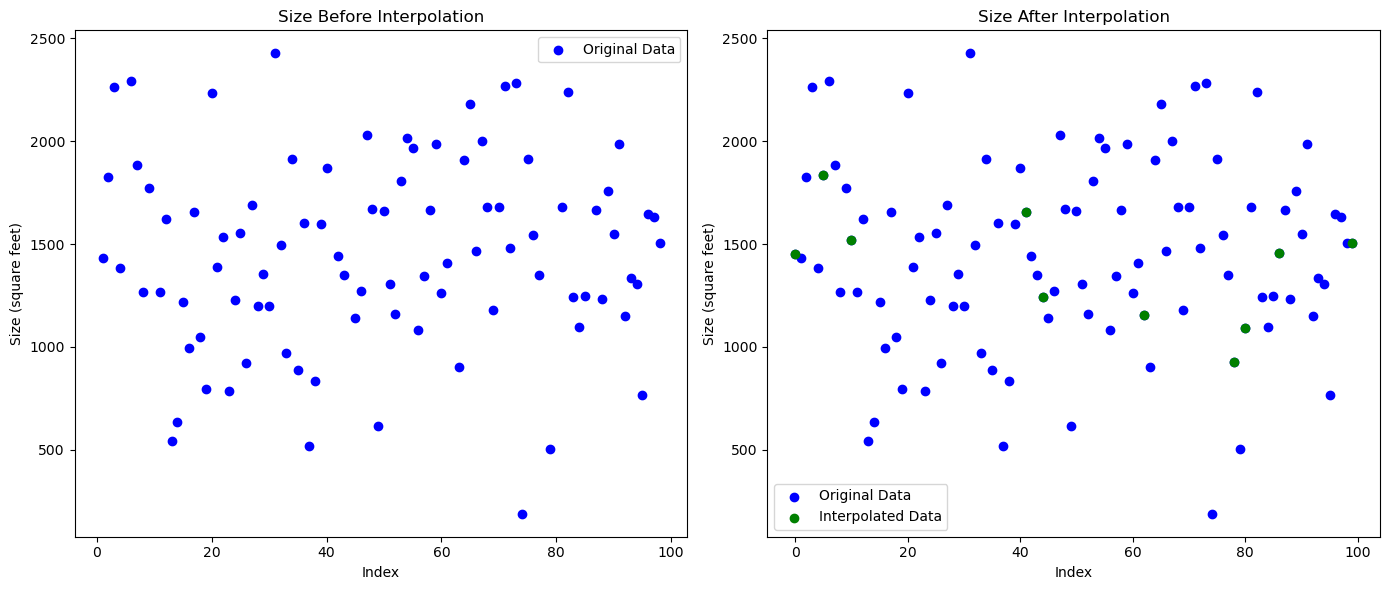

In [30]:
# Ploting before interpolation
plt.figure(figsize=(14, 6))

# Before interpolation: plot original size data only
plt.subplot(1, 2, 1)
plt.scatter(range(len(size)), size, color='blue', label='Original Data')
plt.title('Size Before Interpolation')
plt.xlabel('Index')
plt.ylabel('Size (square feet)')
plt.legend()

# After interpolation: plot original data and interpolated data
plt.subplot(1, 2, 2)
plt.scatter(range(len(size)), df_interpolated['size'], color='blue', label='Original Data')
plt.scatter(missing_indices_size, df_interpolated['size'].iloc[missing_indices_size], color='green', label='Interpolated Data')
plt.title('Size After Interpolation')
plt.xlabel('Index')
plt.ylabel('Size (square feet)')
plt.legend()

plt.tight_layout()
plt.show()

### Plotting prediction for both models

For only a single features (size) from both models we have plotted this graph

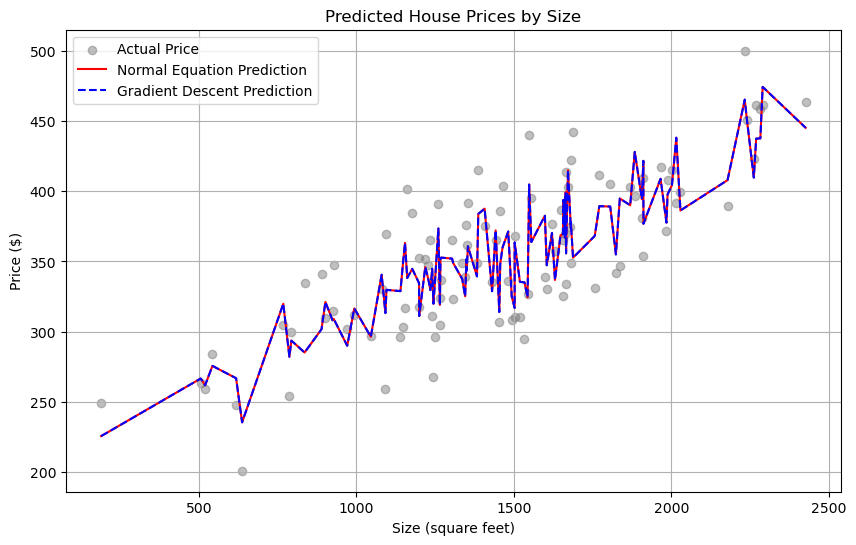

In [31]:
# Plotting predictions for a single feature (size) from both models
sorted_indices = np.argsort(df_interpolated['size'].values)
sorted_size = df_interpolated['size'].values[sorted_indices]
sorted_price = y[sorted_indices]

plt.figure(figsize=(10, 6))
plt.scatter(sorted_size, sorted_price, color='gray', label='Actual Price', alpha=0.5)
plt.plot(sorted_size, y_pred_normal[sorted_indices], 'r-', label='Normal Equation Prediction')
plt.plot(sorted_size, y_pred_gd[sorted_indices], 'b--', label='Gradient Descent Prediction')
plt.xlabel('Size (square feet)')
plt.ylabel('Price ($)')
plt.title('Predicted House Prices by Size')
plt.legend()
plt.grid(True)
plt.show()

### Coefficients and Linear Regression Equation

In [32]:
# Print the coefficients from the Normal Equation
print("Coefficients from the Normal Equation:")
print(beta.flatten())

# Since the gradient descent was performed on scaled features, the coefficients are not directly comparable
# to the Normal Equation coefficients. We can reverse the scaling to compare them.
# Calculate mean and standard deviation for the features (excluding the intercept term)
means = scaler.mean_
stds = scaler.scale_

# Adjust the coefficients from the gradient descent to be on the same scale as the normal equation
# Ensuring that theta_gd is a 1-dimensional array before operations
theta_gd_optimized = theta_gd_optimized.flatten()

intercept_adjustment = np.sum((means / stds) * theta_gd_optimized[1:])

# Creating a new array for unscaled coefficients
theta_gd_unscaled = np.zeros_like(theta_gd_optimized)
theta_gd_unscaled[0] = theta_gd_optimized[0] - intercept_adjustment
theta_gd_unscaled[1:] = theta_gd_optimized[1:] / stds

print("\nCoefficients from the Gradient Descent:")
print(theta_gd_unscaled)

# Print the linear regression equations based on the coefficients
features = ['intercept', 'size', 'bedrooms', 'age']
eq_normal = " + ".join(f"{coef:.2f}*{feat}" for coef, feat in zip(beta.flatten(), features))
eq_gd = " + ".join(f"{coef:.2f}*{feat}" for coef, feat in zip(theta_gd_unscaled, features))

print("\nLinear regression equation from the Normal Equation:")
print(f"price = {eq_normal}")

print("\nLinear regression equation from the Gradient Descent:")
print(f"price = {eq_gd}")

Coefficients from the Normal Equation:
[ 2.12656891e+02  9.64161220e-02  1.16363937e+01 -1.80624670e+00]

Coefficients from the Gradient Descent:
[ 2.12656891e+02  9.64161220e-02  1.16363937e+01 -1.80624670e+00]

Linear regression equation from the Normal Equation:
price = 212.66*intercept + 0.10*size + 11.64*bedrooms + -1.81*age

Linear regression equation from the Gradient Descent:
price = 212.66*intercept + 0.10*size + 11.64*bedrooms + -1.81*age


#### This is the final equation:

- Linear regression equation from the Normal Equation:
price = 212.66*intercept + 0.10*size + 11.64*bedrooms + -1.81*age

- Linear regression equation from the Gradient Descent:
price = 212.66*intercept + 0.10*size + 11.64*bedrooms + -1.81*age